Uncomment and run the cell below if you are in a Google Colab environment. It will:
1. Mount google drive. You will be asked to authenticate and give permissions.
2. Change directory to google drive.
3. Make a directory "hamilton-tutorials"
4. Change directory to it.
5. Clone this repository to your google drive
6. Move your current directory to the hello_world example
7. Install requirements.

This means that any modifications will be saved, and you won't lose them if you close your browser.

In [1]:
## 1. Mount google drive
# from google.colab import drive
# drive.mount('/content/drive')
## 2. Change directory to google drive.
# %cd /content/drive/MyDrive
## 3. Make a directory "hamilton-tutorials"
# !mkdir hamilton-tutorials
## 4. Change directory to it.
# %cd hamilton-tutorials
## 5. Clone this repository to your google drive
# !git clone https://github.com/DAGWorks-Inc/hamilton/
## 6. Move your current directory to the hello_world example
# %cd hamilton/examples/hello_world
## 7. Install requirements.
# %pip install -r requirements.txt
# clear_output()  # optionally clear outputs
# To check your current working directory you can type `!pwd` in a cell and run it.

In [2]:
# Cell 2 - import modules to create part of the DAG from
# We use the autoreload extension that comes with ipython to automatically reload modules when
# the code in them changes.

# import the jupyter extension
%load_ext autoreload
# set it to only reload the modules imported
%autoreload 1

In [3]:
import polars as pl

from hamilton import (
    ad_hoc_utils,
    base,
    driver,
)
from hamilton.function_modifiers import extract_columns
from hamilton.plugins import h_polars

In [4]:
# We'll place the spend calculations into a new module

@extract_columns("signups", "spend")
def base_df(base_df_location: str) -> pl.DataFrame:
    """Loads base dataframe of data.

    :param base_df_location: just showing that we could load this from a file...
    :return:
    """
    return pl.DataFrame(
        {
            "signups": pl.Series([1, 10, 50, 100, 200, 400]),
            "spend": pl.Series([10, 10, 20, 40, 40, 50]),
        }
    )

def avg_3wk_spend(spend: pl.Series) -> pl.Series:
    """Rolling 3 week average spend."""
    return spend.rolling_mean(3)

def spend_per_signup(spend: pl.Series, signups: pl.Series) -> pl.Series:
    """The cost per signup in relation to spend."""
    return spend / signups

def spend_mean(spend: pl.Series) -> float:
    """Shows function creating a scalar. In this case it computes the mean of the entire column."""
    return spend.mean()

def spend_zero_mean(spend: pl.Series, spend_mean: float) -> pl.Series:
    """Shows function that takes a scalar. In this case to zero mean spend."""
    return spend - spend_mean

def spend_std_dev(spend: pl.Series) -> float:
    """Function that computes the standard deviation of the spend column."""
    return spend.std()

def spend_zero_mean_unit_variance(spend_zero_mean: pl.Series, spend_std_dev: float) -> pl.Series:
    """Function showing one way to make spend have zero mean and unit variance."""
    return spend_zero_mean / spend_std_dev

spend_calculations = ad_hoc_utils.create_temporary_module(
    base_df,
    avg_3wk_spend,
    spend_per_signup,
    spend_mean,
    spend_zero_mean,
    spend_std_dev,
    spend_zero_mean_unit_variance,
    module_name="spend_calculations",
)

In [5]:
# Set up the driver, input and output columns
config = {
    "base_df_location": "dummy_value",
}
adapter = base.SimplePythonGraphAdapter(result_builder=h_polars.PolarsDataFrameResult())
dr = driver.Driver(config, spend_calculations, adapter=adapter)
output_columns = [
    "spend",
    "signups",
    "avg_3wk_spend",
    "spend_per_signup",
    "spend_zero_mean_unit_variance",
]

Note: Hamilton collects completely anonymous data about usage. This will help us improve Hamilton over time. See https://github.com/dagworks-inc/hamilton#usage-analytics--data-privacy for details.


shape: (6, 5)
┌───────┬─────────┬───────────────┬──────────────────┬───────────────────────────────┐
│ spend ┆ signups ┆ avg_3wk_spend ┆ spend_per_signup ┆ spend_zero_mean_unit_variance │
│ ---   ┆ ---     ┆ ---           ┆ ---              ┆ ---                           │
│ i64   ┆ i64     ┆ f64           ┆ f64              ┆ f64                           │
╞═══════╪═════════╪═══════════════╪══════════════════╪═══════════════════════════════╡
│ 10    ┆ 1       ┆ null          ┆ 10.0             ┆ -1.064405                     │
│ 10    ┆ 10      ┆ null          ┆ 1.0              ┆ -1.064405                     │
│ 20    ┆ 50      ┆ 13.333333     ┆ 0.4              ┆ -0.483821                     │
│ 40    ┆ 100     ┆ 23.333333     ┆ 0.4              ┆ 0.677349                      │
│ 40    ┆ 200     ┆ 33.333333     ┆ 0.2              ┆ 0.677349                      │
│ 50    ┆ 400     ┆ 43.333333     ┆ 0.125            ┆ 1.257934                      │
└───────┴─────────┴──────────

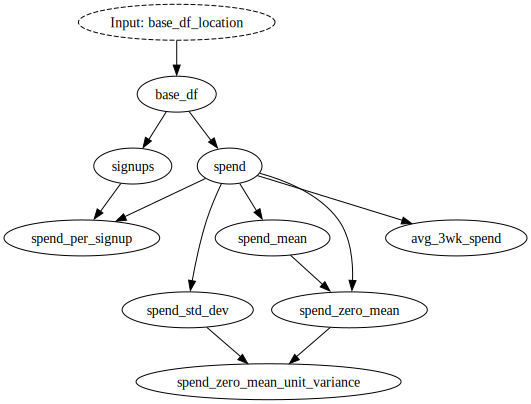

In [6]:
# Execute the driver.

df = dr.execute(output_columns)
print(df)

# To visualize do `pip install "sf-hamilton[visualization]"` if you want these to work
dr.visualize_execution(output_columns, './polars', {"format": "png"})
dr.display_all_functions('./my_full_dag.dot')